# Time-Series Classification
_by Mikhail Karasikov_

## Dataset WISDM

In [1]:
import numpy as np
import pandas

import timeseries
import feature_extraction

dataset = timeseries.TSDataset()
dataset.load_from_mat('../../data/WISDM/preprocessed_large.mat')
print("Dataset size: %d" % len(dataset))
print("Stats:\n", pandas.DataFrame(list(map(lambda ts: ts.shape, dataset.ts)),
                                   columns=['dim', 'len']).describe()[1:].round())

Dataset size: 5205
Stats:
       dim  len
mean    3  200
std     0    0
min     3  200
25%     3  200
50%     3  200
75%     3  200
max     3  200


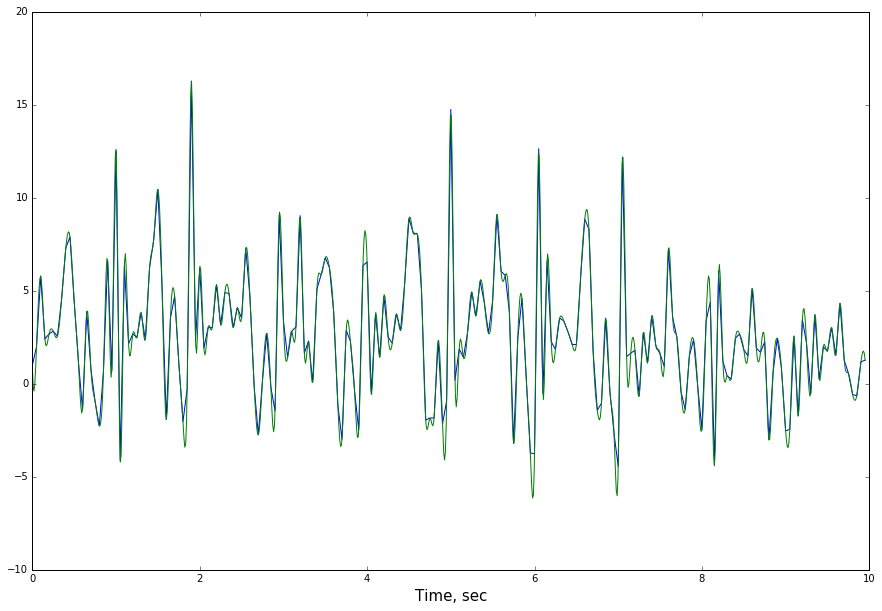

In [2]:
from matplotlib import pylab as plt
%matplotlib inline

x = dataset.ts[5000][0]
t = np.arange(x.size) / 20

freq = 100
t_, x_ = timeseries.transform_frequency(t, x, freq, kind='cubic')

plt.figure(figsize=(15, 10))
plt.plot(t, x)
plt.plot(t_, x_.ravel())
plt.xlabel('Time, sec', size=15)
plt.show()

### Basic Features

In [3]:
X = timeseries.ExtractFeatures(dataset.ts,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: np.sqrt((ts ** 2).sum(0)).mean(),
    lambda ts: np.histogram(ts[0], density=True, bins=10)[0] * (ts[0].max() - ts[0].min()) / 10,
    lambda ts: np.histogram(ts[1], density=True, bins=10)[0] * (ts[1].max() - ts[1].min()) / 10,
    lambda ts: np.histogram(ts[2], density=True, bins=10)[0] * (ts[2].max() - ts[2].min()) / 10,
)
X.shape

(5205, 40)

..................................................
Mean accuracy: 0.972612035851
Confusion matrix:
 [[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.99  0.01  0.    0.    0.  ]
 [ 0.03  0.04  0.89  0.04  0.    0.  ]
 [ 0.02  0.05  0.05  0.88  0.    0.  ]
 [ 0.01  0.    0.    0.    0.98  0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]]


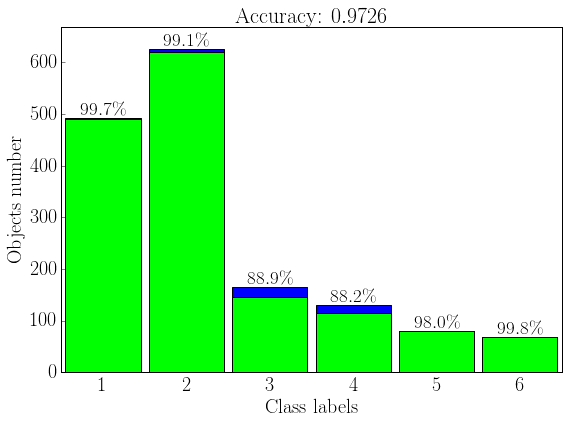

In [4]:
from sklearn import svm, cross_validation
from sklearn.multiclass import OneVsRestClassifier

import multiclass

confusion_mean = multiclass.cross_val_score(
    svm.SVC(gamma=0.12, C=8.5),
    X, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=50, test_size=0.3, random_state=17)
)
multiclass.multiclass_recall_plot(confusion_mean)

### Basic Features + AR(6) Parameters

In [7]:
X = timeseries.ExtractFeatures(dataset.ts,
   lambda ts: feature_extraction.ar_parameters(ts, np.arange(6) + 1),
   lambda ts: ts.mean(1),
   lambda ts: ts.std(1),
   lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
   lambda ts: np.sqrt((ts ** 2).sum(0)).mean(),
)
X.shape

(5205, 31)

In [8]:
#import sklearn.preprocessing
#X_normalized = sklearn.preprocessing.normalize(X, norm='l2', axis=0, copy=True)

X_normalized = X - (X.max(0) + X.min(0)) / 2
X_normalized = X_normalized / X_normalized.max(0)

..................................................
Mean accuracy: 0.984583866837
Confusion matrix:
 [[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.99  0.    0.    0.    0.  ]
 [ 0.01  0.02  0.95  0.02  0.    0.  ]
 [ 0.    0.02  0.04  0.94  0.    0.  ]
 [ 0.01  0.    0.    0.    0.97  0.01]
 [ 0.01  0.    0.    0.    0.01  0.97]]


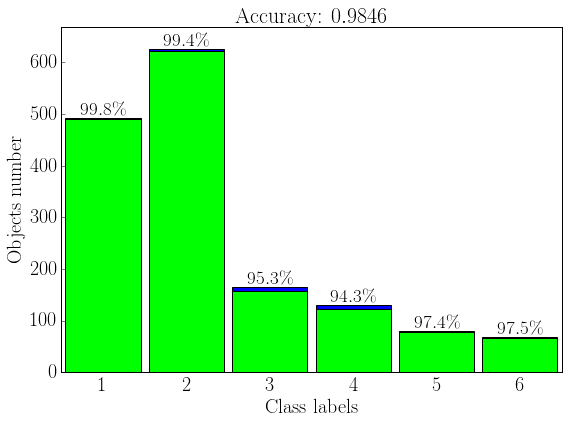

In [9]:
from sklearn.multiclass import OneVsRestClassifier

confusion_mean = multiclass.cross_val_score(
    OneVsRestClassifier(svm.SVC(gamma=0.8, C=8)),
    X_normalized, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=50, test_size=0.3, random_state=17)
)
multiclass.multiclass_recall_plot(confusion_mean)

## Dataset USC-HAD

In [1]:
import numpy as np
import pandas

import timeseries
import feature_extraction

dataset = timeseries.TSDataset()
dataset.load_from_mat('../../data/USC-HAD/USC_HAD_dataset.mat')
print("Dataset size: %d" % len(dataset))
print("Stats:\n", pandas.DataFrame(list(map(lambda ts: ts.shape, dataset.ts)),
                                   columns=['dim', 'len']).describe()[1:].round())

Dataset size: 840
Stats:
       dim    len
mean    6   3347
std     0   1978
min     6    600
25%     6   2000
50%     6   3000
75%     6   4500
max     6  13500


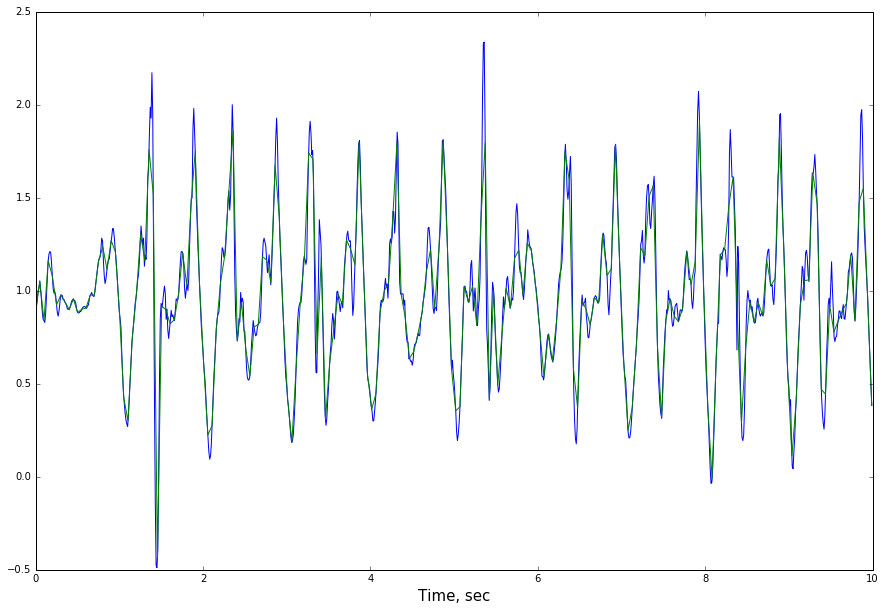

In [2]:
from matplotlib import pylab as plt
%matplotlib inline

x = dataset.ts[200][:, :1000]
t = np.arange(x.shape[1]) / 100

freq = 20
t_, x_ = timeseries.transform_frequency(t, x, freq, kind='linear')

plt.figure(figsize=(15, 10))
plt.plot(t, x[0])
plt.plot(t_, x_[0])
plt.xlabel('Time, sec', size=15)
plt.show()

### Basic Features

In [12]:
X = timeseries.ExtractFeatures(dataset.ts,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: np.sqrt((ts[:3] ** 2).sum(0)).mean(),
    lambda ts: np.hstack(list(map(
                    lambda ts_1d: np.histogram(ts_1d, density=True, bins=10)[0] * (ts_1d.max() - ts_1d.min()) / 10,
                    ts))
    ),
)
X.shape

(840, 79)

....................................................................................................
Mean accuracy: 0.824246031746
Confusion matrix:
 [[ 0.92  0.    0.    0.03  0.03  0.01  0.01  0.    0.    0.    0.    0.  ]
 [ 0.01  0.92  0.01  0.01  0.04  0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.89  0.06  0.    0.02  0.02  0.    0.    0.    0.    0.  ]
 [ 0.03  0.02  0.11  0.74  0.07  0.01  0.02  0.    0.    0.    0.    0.  ]
 [ 0.05  0.08  0.    0.06  0.76  0.    0.05  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.99  0.01  0.    0.    0.    0.    0.  ]
 [ 0.03  0.    0.    0.02  0.05  0.08  0.82  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.93  0.02  0.01  0.02  0.02]
 [ 0.    0.    0.    0.    0.    0.    0.01  0.03  0.84  0.    0.08  0.04]
 [ 0.    0.    0.    0.    0.    0.    0.    0.01  0.    0.99  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.01  0.03  0.    0.56  0.4 ]
 [ 0.    0.    0.    0.  

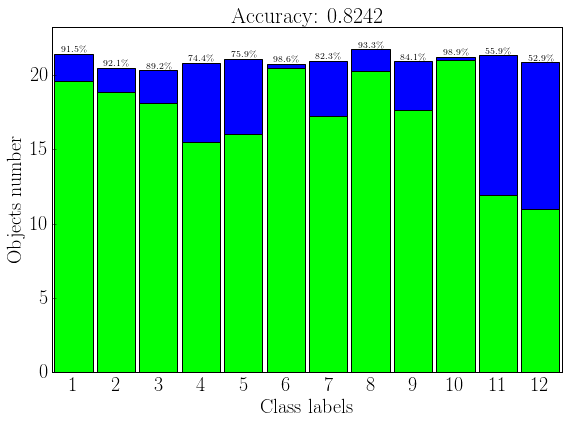

In [13]:
confusion_mean = multiclass.cross_val_score(
    svm.SVC(gamma=0.002, C=80),
    X, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=100, test_size=0.3, random_state=17)
)
multiclass.multiclass_recall_plot(confusion_mean)

### Basic Features + AR(6) Parameters

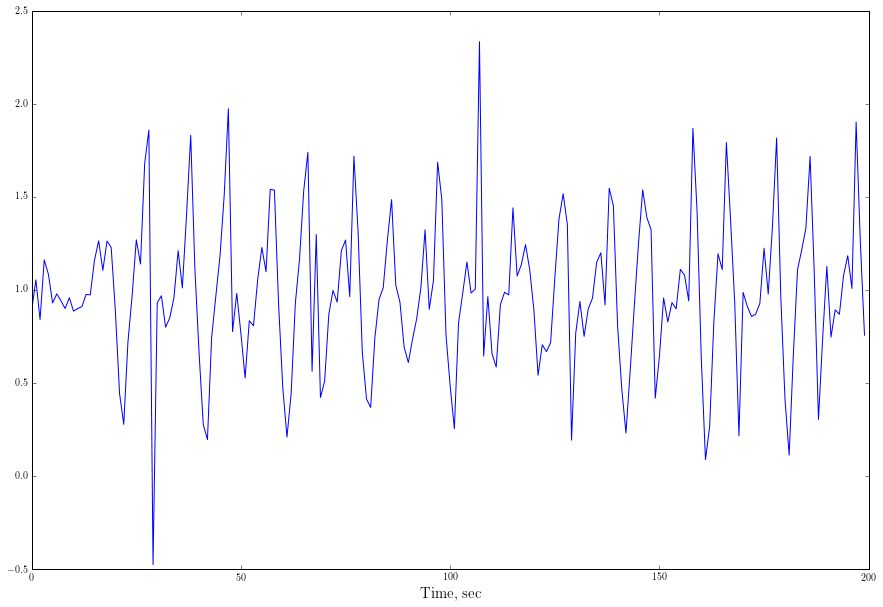

In [32]:
ts_reduced_freq = list(map(
    lambda ts: timeseries.transform_frequency(np.arange(ts.shape[1]) / 100, ts, 20, kind='linear')[1],
    dataset.ts
))

plt.figure(figsize=(15, 10))
plt.plot(ts_reduced_freq[200][0, :200])
plt.xlabel('Time, sec', size=15)
plt.show()

In [15]:
X = timeseries.ExtractFeatures(ts_reduced_freq,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: feature_extraction.ar_parameters(ts, np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[:3] ** 2).sum(0)), np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[3:] ** 2).sum(0)), np.arange(1, 11)),
)
X.shape

X_normalized = X - (X.max(0) + X.min(0)) / 2
X_normalized = X_normalized / X_normalized.max(0)

........................................................................................................................................................................................................
Mean accuracy: 0.923412698413
Confusion matrix:
 [[ 0.93  0.01  0.04  0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.98  0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.04  0.01  0.96  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.    0.01  0.96  0.03  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.01  0.01  0.97  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.93  0.04  0.    0.01  0.02]
 [ 0.    0.    0.    0.    0.    0.    0.    0.05  0.94  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.99  0.    0.  ]


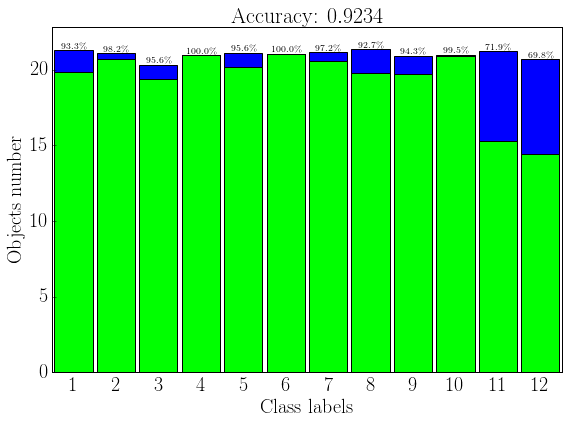

In [16]:
confusion_mean = multiclass.cross_val_score(
    OneVsRestClassifier(svm.SVC(gamma=0.1, C=16)),
    X_normalized, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=200, test_size=0.3, random_state=17)
)
multiclass.multiclass_recall_plot(confusion_mean)

### Fourier Transform

In [29]:
dataset.ts[0].shape[1] % 10

0

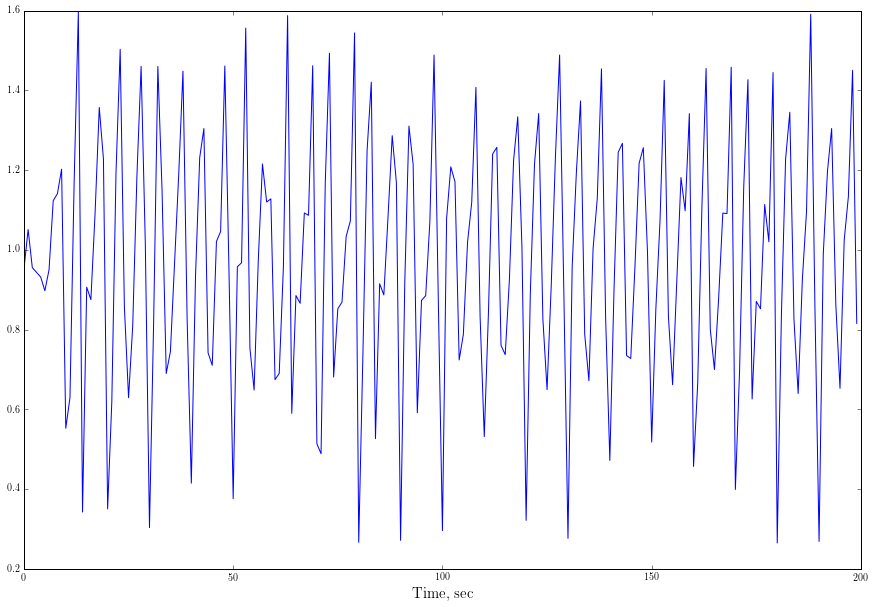

In [42]:
def smooth(ts, window_size):
    ts = ts[:, :ts.shape[1] - (ts.shape[1] % window_size)]
    return ts.reshape(ts.shape[0], -1, window_size).mean(2)

ts_smoothed = list(map(
    lambda ts: smooth(ts, 10),
    dataset.ts
))

plt.figure(figsize=(15, 10))
plt.plot(ts_smoothed[200][0, :200])
plt.xlabel('Time, sec', size=15)
plt.show()

In [43]:
X = timeseries.ExtractFeatures(ts_smoothed,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: feature_extraction.ar_parameters(ts, np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[:3] ** 2).sum(0)), np.arange(1, 11)),
    lambda ts: feature_extraction.ar_parameters(np.sqrt((ts[3:] ** 2).sum(0)), np.arange(1, 11)),
    lambda ts: feature_extraction.dft_features(np.sqrt((ts[:3] ** 2).sum(0)), 10)[1:],
    lambda ts: feature_extraction.dft_features(np.sqrt((ts[3:] ** 2).sum(0)), 10)[1:],
)
X.shape

X_normalized = X - (X.max(0) + X.min(0)) / 2
X_normalized = X_normalized / X_normalized.max(0)

........................................................................................................................................................................................................
Mean accuracy: 0.975734126984
Confusion matrix:
 [[ 0.97  0.    0.    0.01  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.98  0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.    0.99  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.01  0.98  0.01  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.    0.    0.01  0.95  0.02  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.99  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.91  0.09  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.05  0.95  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]


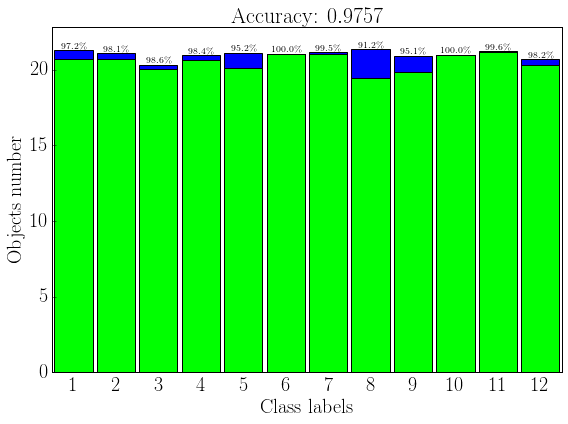

In [45]:
import multiclass
from sklearn import svm, cross_validation

confusion_mean = multiclass.cross_val_score(
    svm.SVC(gamma=0.04, C=16),
    X_normalized, dataset.label,
    cross_validation.ShuffleSplit(dataset.label.size, n_iter=200, test_size=0.3, random_state=17)
)
multiclass.multiclass_recall_plot(confusion_mean)